In [1]:
#import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb

In [2]:
# Read the dataset
df = pd.read_csv('../Dataset/ACB-Historical-Data_Group-9.csv',index_col='Date', parse_dates=True)
df.dropna() #Drop missing value
df = df.sort_values(by='Date', ascending=True)
df =df.reset_index(drop=True) #Reset the index
df.head()

,Price,Open,High,Low,Vol.,Change %
0,"11,361.00","11,285.20","11,398.80","11,171.60",3.91M,1.01%
1,"11,512.40","11,361.00","11,550.30","11,323.10",8.24M,1.33%
2,"11,474.60","11,512.40","11,626.00","11,398.80",6.51M,-0.33%
3,"11,474.60","11,436.70","11,512.40","11,361.00",3.11M,0.00%
4,"11,550.30","11,512.40","11,626.00","11,474.60",8.72M,0.66%


In [3]:
print(df.dtypes)

Price       object
Open        object
High        object
Low         object
Vol.        object
Change %    object
dtype: object


In [4]:
# Hàm chuyển đổi
def convert_str_to_number(str):
    return float(str.replace(',', ''))

def convert_change_to_number(change_str):
    return float(change_str.strip('%')) / 100

def convert_volume_to_number(volume_str):
    factor = {'K': 1000, 'M': 1000000, 'B': 1000000000}
    return int(float(volume_str[:-1]) * factor[volume_str[-1]]) if volume_str[-1] in factor else int(volume_str)

# Áp dụng hàm chuyển đổi cho các cột giá trị
df['Price'], df['Open'], df['High'], df['Low'] = [df[col].apply(convert_str_to_number) for col in ['Price', 'Open', 'High', 'Low']]
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df["Vol."] = df["Vol."].apply(convert_volume_to_number)

print(df)
df.describe()

        Price     Open     High      Low      Vol.  Change %
0     11361.0  11285.2  11398.8  11171.6   3910000    0.0101
1     11512.4  11361.0  11550.3  11323.1   8240000    0.0133
2     11474.6  11512.4  11626.0  11398.8   6510000   -0.0033
3     11474.6  11436.7  11512.4  11361.0   3110000    0.0000
4     11550.3  11512.4  11626.0  11474.6   8720000    0.0066
...       ...      ...      ...      ...       ...       ...
1303  29450.0  29500.0  29850.0  29250.0   7540000    0.0068
1304  29650.0  29700.0  29700.0  29300.0  10690000    0.0068
1305  29250.0  29700.0  29750.0  29250.0  13450000   -0.0135
1306  25565.2  25347.8  25565.2  25087.0  15080000   -0.1260
1307  24650.0  25000.0  25300.0  24650.0  11120000   -0.0358

[1308 rows x 6 columns]


,Price,Open,High,Low,Vol.,Change %
count,1308.000000,1308.000000,1308.000000,1308.000000,1.308000e+03,1308.000000
mean,19251.080122,19252.003287,19477.664526,19027.109098,7.817892e+06,0.000792
std,5987.083276,5994.933392,6038.280436,5938.080094,6.166880e+06,0.019501
min,8763.100000,7926.200000,9255.400000,7926.200000,7.420600e+05,-0.175200
25%,12075.875000,12110.800000,12258.375000,11914.000000,3.487500e+06,-0.008000
50%,20466.000000,20466.000000,20674.000000,20219.500000,6.005000e+06,0.000000
75%,24412.000000,24056.000000,24568.000000,23891.500000,1.023500e+07,0.009100
max,30360.000000,30400.000000,30560.000000,29300.000000,4.873000e+07,0.096100


In [5]:
df1=df.reset_index()['Price']
df1

0       11361.0
1       11512.4
2       11474.6
3       11474.6
4       11550.3
         ...   
1303    29450.0
1304    29650.0
1305    29250.0
1306    25565.2
1307    24650.0
Name: Price, Length: 1308, dtype: float64

In [6]:
# split the data into train and test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

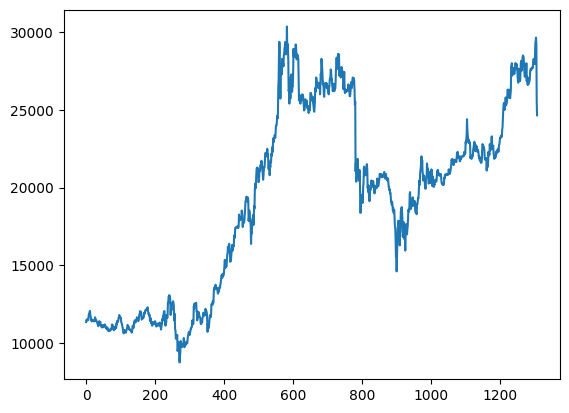

In [7]:
plt.plot(df1)

In [8]:
# Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [9]:
# df1.shape
print(df1)

[[0.12029041]
 [0.12730068]
 [0.12555043]
 ...
 [0.94860373]
 [0.77798666]
 [0.7356102 ]]


In [10]:
# 4. split the data into train and test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size 

train_data = df1[0:train_size,:]
test_data = df1[train_size:len(df1),:1]

In [11]:
#Training process
# a. convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

# b. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [12]:
print(X_train)

[[0.12029041 0.12730068 0.12555043 ... 0.13782534 0.13431557 0.13256069]
 [0.12730068 0.12555043 0.12555043 ... 0.13431557 0.13256069 0.13449152]
 [0.12555043 0.12555043 0.12905556 ... 0.13256069 0.13449152 0.12765258]
 ...
 [0.57280906 0.5592423  0.58827424 ... 0.38329112 0.34847131 0.38329112]
 [0.5592423  0.58827424 0.59021897 ... 0.34847131 0.38329112 0.39296844]
 [0.58827424 0.59021897 0.56891961 ... 0.38329112 0.39296844 0.44709657]]


In [13]:
# # 8. Define GRU Model
# model = xgb.XGBRegressor(
#              colsample_bynode=1, colsample_bytree=1, gamma=0.01,
#              importance_type='gain', 
#              learning_rate=0.1, max_delta_step=0,
#              max_depth=8, min_child_weight=1, 
#              n_estimators=400,
#              n_jobs=1, nthread=None, 
#              objective='reg:squarederror',
#              random_state=42)

In [14]:
# 8. Define GRU Model
model = xgb.XGBRegressor(
                        objective='reg:squarederror',
                        n_estimators=1000,
                        learning_rate=0.01,
                        max_depth=6,
                        subsample=0.8,
                        colsample_bytree=0.8)

In [15]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [16]:
# 7. Dự báo dữ liệu test, val
y_pred=model.predict(X_test)
y_pred



array([0.5476141 , 0.54730433, 0.5540756 , 0.562281  , 0.566143  ,
       0.5662785 , 0.5744762 , 0.5687633 , 0.5666445 , 0.5662171 ,
       0.5662947 , 0.5618698 , 0.56582975, 0.5671993 , 0.5652134 ,
       0.5613349 , 0.5475666 , 0.5379091 , 0.52824146, 0.52759576,
       0.51694995, 0.5176178 , 0.516774  , 0.5269656 , 0.5458244 ,
       0.5467726 , 0.55825543, 0.55844694, 0.56213146, 0.5637499 ,
       0.56153345, 0.5632127 , 0.5616812 , 0.5623799 , 0.56280494,
       0.56327057, 0.5626105 , 0.5705739 , 0.5618344 , 0.5612775 ,
       0.5613047 , 0.56193596, 0.56225663, 0.56912553, 0.57623434,
       0.58315855, 0.58608407, 0.5873056 , 0.5882353 , 0.582814  ,
       0.57866156, 0.5789437 , 0.5831816 , 0.58647645, 0.5902592 ,
       0.5952436 , 0.5908399 , 0.5886063 , 0.59229755, 0.59322447,
       0.59432304, 0.61165094, 0.6136303 , 0.6218055 , 0.6058112 ,
       0.6138732 , 0.61114943, 0.5984159 , 0.5966596 , 0.591181  ,
       0.5971722 , 0.5976925 , 0.597831  , 0.5976659 , 0.59808

In [17]:
# 12. inverse transform the scaled ytest data back to its original scale.
y_pred_ = scaler.inverse_transform(y_pred.reshape(-1,1))
y_test_ = scaler.inverse_transform(y_test.reshape(-1,1))
# 12. Đánh giá độ chính xác thuật toán 
test_rmse = np.sqrt(np.mean((y_pred_ - y_test_)**2))
print('Testing RMSE:', test_rmse)

from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test_, y_pred_)
print('Testing MAE:', test_mae)

from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_test_, y_pred_)
print('Testing MAPE:', test_mape)  

Testing RMSE: 419.3048682865193
Testing MAE: 293.45145012842477
Testing MAPE: 0.012042134655372337


In [18]:
#Dự đoán 30 ngày tiếp theo
x_input = test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = time_step
i = 0
pred_days = 30
while(i < pred_days):
    
    if(len(temp_input) > time_step):
        
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1,-1)
        
        yhat = model.predict(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i = i+1
        
    else:
        yhat = model.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i = i+1
        
print("Output of predicted next days: ", lst_output)

1 day output [0.71491396]
2 day output [0.7170926]
3 day output [0.7302846]
4 day output [0.7492363]
5 day output [0.75898635]
6 day output [0.7653256]
7 day output [0.7622499]
8 day output [0.76193655]
9 day output [0.7641372]
10 day output [0.7671413]
11 day output [0.76627594]
12 day output [0.76315117]
13 day output [0.7604465]
14 day output [0.76350504]
15 day output [0.76716506]
16 day output [0.7687897]
17 day output [0.7710672]
18 day output [0.77617943]
19 day output [0.77201957]
20 day output [0.7775436]
21 day output [0.7658056]
22 day output [0.7635108]
23 day output [0.71394426]
24 day output [0.68990785]
25 day output [0.6738639]
26 day output [0.66785836]
27 day output [0.6474393]
28 day output [0.6037908]
29 day output [0.5594318]
Output of predicted next days:  [0.7215802669525146, 0.7149139642715454, 0.7170925736427307, 0.730284571647644, 0.7492362856864929, 0.7589863538742065, 0.7653256058692932, 0.7622498869895935, 0.7619365453720093, 0.7641372084617615, 0.767141282

In [19]:
y_pred = y_pred.reshape(-1,1)
y_pred = scaler.inverse_transform(y_pred)

print("Test data prediction:", y_pred.shape)

Test data prediction: (292, 1)


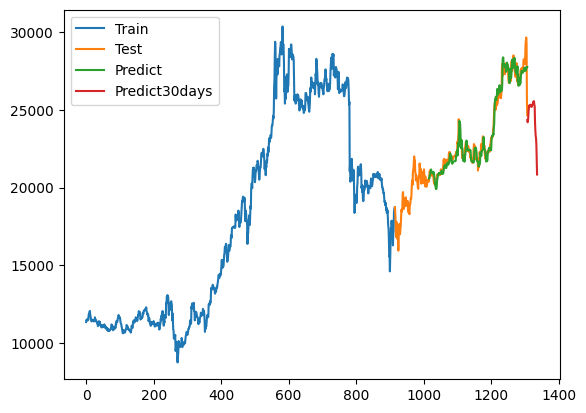

In [20]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,y_pred)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)-1+len(scaler.inverse_transform(np.array(lst_output).reshape(-1,1))), step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(np.array(lst_output).reshape(-1,1)))
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

In [21]:
#Dự đoán 60 ngày tiếp theo
x_input = test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = time_step
i = 0
pred_days = 60
while(i < pred_days):
    
    if(len(temp_input) > time_step):
        
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1,-1)
        
        yhat = model.predict(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i = i+1
        
    else:
        yhat = model.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i = i+1
        
print("Output of predicted next days: ", lst_output)

1 day output [0.71491396]
2 day output [0.7170926]
3 day output [0.7302846]
4 day output [0.7492363]
5 day output [0.75898635]
6 day output [0.7653256]
7 day output [0.7622499]
8 day output [0.76193655]
9 day output [0.7641372]
10 day output [0.7671413]
11 day output [0.76627594]
12 day output [0.76315117]
13 day output [0.7604465]
14 day output [0.76350504]
15 day output [0.76716506]
16 day output [0.7687897]
17 day output [0.7710672]
18 day output [0.77617943]
19 day output [0.77201957]
20 day output [0.7775436]
21 day output [0.7658056]
22 day output [0.7635108]
23 day output [0.71394426]
24 day output [0.68990785]
25 day output [0.6738639]
26 day output [0.66785836]
27 day output [0.6474393]
28 day output [0.6037908]
29 day output [0.5594318]
30 day output [0.5462766]
31 day output [0.53746915]
32 day output [0.53870165]
33 day output [0.5409175]
34 day output [0.540659]
35 day output [0.5442581]
36 day output [0.5358579]
37 day output [0.5391172]
38 day output [0.5363055]
39 day o

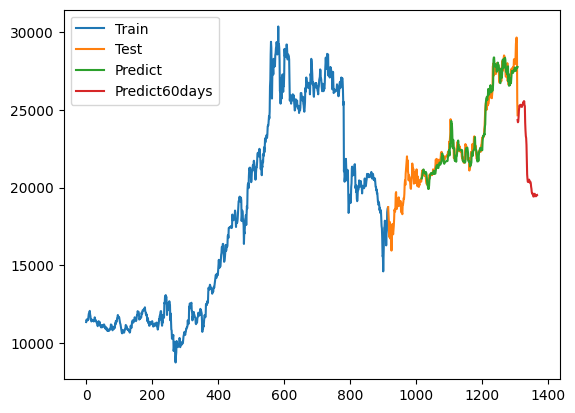

In [22]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index, y_pred)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)-1+len(scaler.inverse_transform(np.array(lst_output).reshape(-1,1))), step=1)
plt.plot(prediect_data_index, scaler.inverse_transform(np.array(lst_output).reshape(-1,1)))

plt.legend(['Train', 'Test', 'Predict', 'Predict60days'])
plt.show()

In [23]:
#Dự đoán 90 ngày tiếp theo
x_input = test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = time_step
i = 0
pred_days = 90
while(i < pred_days):
    
    if(len(temp_input) > time_step):
        
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1,-1)
        
        yhat = model.predict(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i = i+1
        
    else:
        yhat = model.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i = i+1
        
print("Output of predicted next days: ", lst_output)

1 day output [0.71491396]
2 day output [0.7170926]
3 day output [0.7302846]
4 day output [0.7492363]
5 day output [0.75898635]
6 day output [0.7653256]
7 day output [0.7622499]
8 day output [0.76193655]
9 day output [0.7641372]
10 day output [0.7671413]
11 day output [0.76627594]
12 day output [0.76315117]
13 day output [0.7604465]
14 day output [0.76350504]
15 day output [0.76716506]
16 day output [0.7687897]
17 day output [0.7710672]
18 day output [0.77617943]
19 day output [0.77201957]
20 day output [0.7775436]
21 day output [0.7658056]
22 day output [0.7635108]
23 day output [0.71394426]
24 day output [0.68990785]
25 day output [0.6738639]
26 day output [0.66785836]
27 day output [0.6474393]
28 day output [0.6037908]
29 day output [0.5594318]
30 day output [0.5462766]
31 day output [0.53746915]
32 day output [0.53870165]
33 day output [0.5409175]
34 day output [0.540659]
35 day output [0.5442581]
36 day output [0.5358579]
37 day output [0.5391172]
38 day output [0.5363055]
39 day o

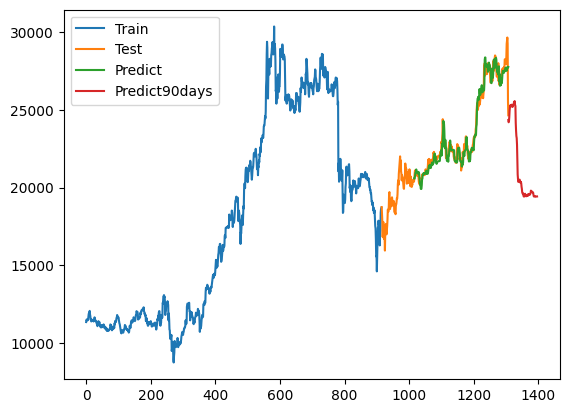

In [24]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index, y_pred)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)-1+len(scaler.inverse_transform(np.array(lst_output).reshape(-1,1))), step=1)
plt.plot(prediect_data_index, scaler.inverse_transform(np.array(lst_output).reshape(-1,1)))

plt.legend(['Train', 'Test', 'Predict', 'Predict90days'])
plt.show()